In [1]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scipy.io as io
import os
import pickle
#######################################################################################################################
import computeamplification as CA
%matplotlib inline

In [2]:
def stable_logsumexp(x):
    a = np.max(x)
    return a+np.log(np.sum(np.exp(x-a)))

def log_comb(n, k):
    return (sp.gammaln(n + 1) -sp.gammaln(k + 1) - sp.gammaln(n - k + 1))
########################################################################################################################
######################################## RDP with Sampling #############################################################
########################################################################################################################
def RDP_comp_integer_order_samp(eps0, n, q, lambd):
    if lambd == 1:
        D = 0
    else:
        ex_eps0 = np.exp(eps0)
        m = (q*n-1)/(2*ex_eps0)+1
        c = 2*((ex_eps0-1/ex_eps0)**2)/(m)
        a = []
        a.append(0)
        term = log_comb(lambd,2)+2*np.log(q)+np.log(((ex_eps0-1)**2)/(m*ex_eps0))+np.log(4)
        a.append(term)
        for j in range(3,lambd+1,1):
            term = log_comb(lambd, j)+np.log(j)+sp.gammaln(j/2)+(j/2)*np.log(c)+j*np.log(q)
            a.append(term)
        a.append(-(q*n-1)/(8*ex_eps0)+np.log(((1+q*(np.exp(eps0)-np.exp(-eps0)))**lambd)-1-q*lambd*(np.exp(eps0)-np.exp(-eps0))))
        D = stable_logsumexp(a)/(lambd-1)
    return D

def RDP_comp_samp(eps0, n, q, lambd):
    D = np.zeros_like(lambd,dtype=float)
    for i in range(0,len(lambd),1):
        c = int(np.ceil(lambd[i]))
        f = int(np.floor(lambd[i]))
        if c==f:
            D[i] = RDP_comp_integer_order_samp(eps0, n, q, f)
        else:
            a = c-lambd[i]
            D[i] = (f-1)*a*RDP_comp_integer_order_samp(eps0, n, q, f)
            D[i] += (c-1)*(1-a)*RDP_comp_integer_order_samp(eps0, n, q, c)
            D[i] /= (lambd[i]-1)
    return D
########################################################################################################################
################################## 1st Upper bound Theorem1 ############################################################
########################################################################################################################
def RDP_comp_integer_order(eps0,n,lambd):
    if lambd == 1:
        D = 0
    else:
        ex_eps0 = np.exp(eps0)
        m = (n-1)/(2*ex_eps0)+1
        c = ((ex_eps0-1/ex_eps0)**2)/(2*m)
        a = []
        a.append(0)
        term = np.log(((ex_eps0-1)**2)/(m*ex_eps0))+log_comb(lambd,2)
        a.append(term)
        for j in range(3,lambd+1,1):
            term = log_comb(lambd, j)+np.log(j)+sp.gammaln(j/2)+(j/2)*np.log(c) 
            a.append(term)
        a.append(-(n-1)/(8*ex_eps0)+eps0*lambd)
        D = stable_logsumexp(a)/(lambd-1)
    return D

def RDP_comp(eps0,n,lambd):
    D = np.zeros_like(lambd,dtype=float)
    for i in range(0,len(lambd),1):
        c = int(np.ceil(lambd[i]))
        f = int(np.floor(lambd[i]))
        if c==f:
            D[i] = RDP_comp_integer_order(eps0,n,f)
        else:
            a = c-lambd[i]
            D[i] = (f-1)*a*RDP_comp_integer_order(eps0,n,f)
            D[i] += (c-1)*(1-a)*RDP_comp_integer_order(eps0,n,c)
            D[i] /= (lambd[i]-1)
    return D
########################################################################################################################
################################# Lower bound Theorem 3 ################################################################
########################################################################################################################
def lower_bound_RDP(eps0,n,q,lambd):
    D = np.zeros_like(lambd,dtype=float)
    ex_eps0 = np.exp(eps0)
    p = 1/(ex_eps0+1)
    m = int(q*n)
    k = np.arange(0,m+1,1)
    comb = [log_comb(m,j) for j in k]
    for i in range(0,len(lambd),1):
        a = comb + k*np.log(p) + (m-k)*np.log(1-p) 
        a += lambd[i]*np.log((1-q)+q*(k*(ex_eps0-1/ex_eps0)/m+1/ex_eps0))
        D[i] = stable_logsumexp(a)
        D[i]/= lambd[i]-1
    return D
########################################################################################################################
############################################ Uniform Sub-Sampling ######################################################
########################################################################################################################
def uniform_subsampled_integer_order(eps0, n, q, lambd, rdp_fun):
    if lambd == 1:
        D = 0
    else:
        a = []
        a.append(0)
        m = int(q*n)
        D = rdp_fun(eps0,m,np.arange(2,lambd+1,1))
        term = log_comb(lambd,2)+2*np.log(q)+np.log(2)+ D[0]
        a.append(term)
        for j in range(3,lambd+1,1):
            term = log_comb(lambd, j)+j*np.log(q)+np.log(2)+(j-1)*D[j-2]
            a.append(term)
        D = stable_logsumexp(a)/(lambd-1)
    return D

def uniform_subsampled(eps0, n, q, lambd, rdp_fun):
    D = np.zeros_like(lambd,dtype=float)
    for i in range(0,len(lambd),1):
        c = int(np.ceil(lambd[i]))
        f = int(np.floor(lambd[i]))
        if c==f:
            D[i] = uniform_subsampled_integer_order(eps0, n, q, f, rdp_fun)
        else:
            a = c-lambd[i]
            D[i] = (f-1)*a*uniform_subsampled_integer_order(eps0, n, q, f, rdp_fun)
            D[i] += (c-1)*(1-a)*uniform_subsampled_integer_order(eps0, n, q, c, rdp_fun)
            D[i] /= (lambd[i]-1)
    return D
########################################################################################################################
############################################ Optimize from RDP to DP ###################################################
########################################################################################################################
def optimize_RDP_To_DP(delta,acc,eps0,n,q,T,rdp_fun):
    if eps0>1:
        lmax = np.array(10**4)
    else:
        lmax = np.array(10**5)
    lmin = np.array(1)
    err = lmax
    while (err>acc):
        l = []
        l.append((lmax+lmin)/2)
        l.append((lmax+lmin)/2+0.01)
        D = T*rdp_fun(eps0,n,q,l)+np.log(1-1/np.array(l))-np.log(delta*np.array(l))/(np.array(l)-1)
        err = lmax-lmin
        if D[0]>D[1]:
            lmin = l[0]
            eps = D[1]
        else:
            lmax = l[0]
            eps = D[0]
    return eps
########################################################################################################################
############################################ Optimize from RDP to DP ###################################################
########################################################################################################################
def optimize_RDP_To_DP_2(delta,acc,eps0,n,q,T,rdp_fun,rdp_fun2):
#     lambd =[2,4,8,16,32,64,256,512,700,1024,1500,2048,3000,4096,6000,8192,10000]
#     D = T*rdp_fun(eps0,n,q,lambd,rdp_fun2)+np.log(1-1/np.array(lambd))-np.log(delta*np.array(lambd))/(np.array(lambd)-1)
#     eps = np.amin(D)
    if eps0>1:
        lmax = np.array(10**3)
    else:
        lmax = np.array(10**3)
    lmin = np.array(1)
    err = lmax
    while (err>acc):
        l = []
        l.append((lmax+lmin)/2)
        l.append((lmax+lmin)/2+0.01)
        D = T*rdp_fun(eps0,n,q,l,rdp_fun2)+np.log(1-1/np.array(l))-np.log(delta*np.array(l))/(np.array(l)-1)
        err = lmax-lmin
        if D[0]>D[1]:
            lmin = l[0]
            eps = D[1]
        else:
            lmax = l[0]
            eps = D[0]
    return eps


In [4]:
###############################################################################################################
################################ Approximate DP as a function of T ############################################
###############################################################################################################

eps0 = 2
n = 10**6
q = 1-1/n
print(q)
lambd = np.geomspace(100, 101, num=2, dtype=int)
upper_1 = RDP_comp_samp(eps0, n, q, lambd)
upper_3 = RDP_comp(eps0, n, lambd)
upper_2 = uniform_subsampled(eps0, n, q, lambd, RDP_comp)

0.999999
[0.06169516 0.06190106]
[0.71265863 0.71260372]
[0.0234454  0.02359889]


### Comparison Between several bounds for composition: 

1. via Lower bound (Theorem 2)
2. via upper bound (Theorem 1)
3. The numeric bound of Vitaly et al. [FMT'20] + Strong Composition[KOV15] 
3. via RDP of shuffled model [GDD'21] + Subsampled RDP[ZW19] 

upper: 0
upper_2: 0
lower: 0
clones: 0
upper: 1
upper_2: 1
lower: 1
clones: 1
upper: 2
upper_2: 2
lower: 2
clones: 2
upper: 3
upper_2: 3
lower: 3
clones: 3
upper: 4
upper_2: 4
lower: 4
clones: 4
upper: 5
upper_2: 5
lower: 5
clones: 5
upper: 6
upper_2: 6
lower: 6
clones: 6
upper: 7
upper_2: 7
lower: 7
clones: 7
upper: 8
upper_2: 8
lower: 8
clones: 8
upper: 9
upper_2: 9
lower: 9
clones: 9


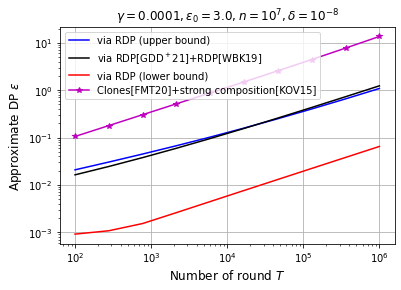

In [20]:
###############################################################################################################
################################ Approximate DP as a function of T ############################################
###############################################################################################################

delta = 1e-8
eps0 = 3
n = 10**7
q = 0.0001

T = np.geomspace(100, 1000000, num=10, dtype=int)
eps_upper = np.zeros_like(T,dtype=float) 
eps_upper_samp = np.zeros_like(T,dtype=float) 
eps_lower = np.zeros_like(T,dtype=float) 
eps_clones = np.zeros_like(T,dtype=float) 
eps_blanket = np.zeros_like(T,dtype=float) 
epsx0 = np.exp(eps0)
for t in range(len(T)):
    eps_upper[t] = optimize_RDP_To_DP(delta,0.01,eps0,n, q, T[t], RDP_comp_samp)
    print('upper:', t)
    eps_upper_samp[t] = optimize_RDP_To_DP_2(delta,1,eps0,n,q,T[t], uniform_subsampled,RDP_comp)
    print('upper_2:', t)
    eps_lower[t] = optimize_RDP_To_DP(delta,0.01,eps0,n, q, T[t], lower_bound_RDP)
    print('lower:', t)
    delta1 = 1-(1-delta)/((1-delta/(2*T[t]))**T[t])
    epsh = CA.numericalanalysis(int(q*n), eps0, delta/(2*q*T[t]), 3, 100, True)
    x = np.log(q*n/(16*np.log(2/delta)))
    if eps0>x:
        epsh = eps0
    epsh = np.log(1+q*(np.exp(epsh)-1))
    a = []
    a.append(T[t]*epsh)
    a.append(T[t]*((np.exp(epsh)-1)*epsh/(np.exp(epsh)+1))+epsh*np.sqrt(2*T[t]*np.log(np.exp(1)+np.sqrt(T[t])*epsh/delta1)))
    a.append(T[t]*((np.exp(epsh)-1)*epsh/(np.exp(epsh)+1))+epsh*np.sqrt(2*T[t]*np.log(1/delta1)))
    eps_clones[t] = np.amin(a)
    print('clones:', t)
fig=plt.figure()
plt.plot(T, eps_upper,'b-',label='via RDP (upper bound)')
plt.plot(T, eps_upper_samp,'k-',label='via RDP[GDD$^+$21]+RDP[WBK19] ')
plt.plot(T, eps_lower,'r-',label='via RDP (lower bound)')
plt.plot(T, eps_clones,'m-*',label='Clones[FMT20]+strong composition[KOV15]')
plt.title('$\gamma={}, \epsilon_0 = {:.1f}, n = 10^{}, \\delta = 10^{}$'.format(q,eps0, '{%d}'%np.log10(n), '{-%d}' % np.log10(1/delta)))
plt.ylabel( 'Approximate DP $\epsilon$',fontsize=12)
plt.xlabel("Number of round $T$",fontsize=12)
plt.grid()
plt.legend(fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.show()
fig.savefig('dp_vs_T.pdf',dpi=350)

C:\Users\ANT-PC\AppData\Local\Temp/ipykernel_16292/3578104907.py:24: RuntimeWarning: overflow encountered in double_scalars
  a.append(-(q*n-1)/(8*ex_eps0)+np.log(((1+q*(np.exp(eps0)-np.exp(-eps0)))**lambd)-1-q*lambd*(np.exp(eps0)-np.exp(-eps0))))
C:\Users\ANT-PC\AppData\Local\Temp/ipykernel_16292/3578104907.py:3: RuntimeWarning: invalid value encountered in subtract
  return a+np.log(np.sum(np.exp(x-a)))


upper: 0
upper_2: 0
lower: 0
clones: 0
upper: 1
upper_2: 1
lower: 1
clones: 1
upper: 2
upper_2: 2
lower: 2
clones: 2
upper: 3
upper_2: 3
lower: 3
clones: 3
upper: 4
upper_2: 4
lower: 4
clones: 4
upper: 5
upper_2: 5
lower: 5
clones: 5
upper: 6
upper_2: 6
lower: 6
clones: 6
upper: 7
upper_2: 7
lower: 7
clones: 7
upper: 8
upper_2: 8
lower: 8
clones: 8
upper: 9
upper_2: 9
lower: 9
clones: 9


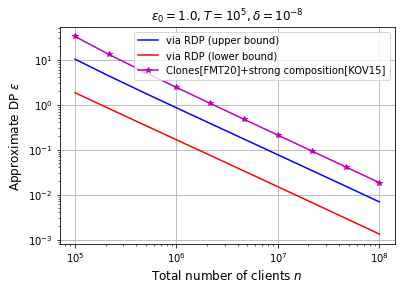

In [26]:
###############################################################################################################
################################ Approximate DP as a function of T ############################################
###############################################################################################################
delta = 1e-8
eps0 = 1
T = 10**5


n = np.geomspace(100000, 100000000, num=10, dtype=int)
eps_upper = np.zeros_like(n,dtype=float) 
eps_upper_samp = np.zeros_like(n,dtype=float) 
eps_lower = np.zeros_like(n,dtype=float) 
eps_clones = np.zeros_like(n,dtype=float) 
eps_blanket = np.zeros_like(n,dtype=float) 
epsx0 = np.exp(eps0)
for t in range(len(n)):
    q = 10000/n[t]
    eps_upper[t] = optimize_RDP_To_DP(delta,0.01,eps0,n[t], q, T, RDP_comp_samp)
    print('upper:', t)
    eps_upper_samp[t] = optimize_RDP_To_DP_2(delta,1,eps0,n[t],q,T, uniform_subsampled,RDP_comp)
    print('upper_2:', t)
    eps_lower[t] = optimize_RDP_To_DP(delta,0.01,eps0,n[t], q, T, lower_bound_RDP)
    print('lower:', t)
    delta1 = 1-(1-delta)/((1-delta/(2*T))**T)
    epsh = CA.numericalanalysis(int(q*n[t]), eps0, delta/(2*q*T), 3, 100, True)
    x = np.log(q*n[t]/(16*np.log(2/delta)))
    if eps0>x:
        epsh = eps0
    epsh = np.log(1+q*(np.exp(epsh)-1))
    a = []
    a.append(T*epsh)
    a.append(T*((np.exp(epsh)-1)*epsh/(np.exp(epsh)+1))+epsh*np.sqrt(2*T*np.log(np.exp(1)+np.sqrt(T)*epsh/delta1)))
    a.append(T*((np.exp(epsh)-1)*epsh/(np.exp(epsh)+1))+epsh*np.sqrt(2*T*np.log(1/delta1)))
    eps_clones[t] = np.amin(a)
    print('clones:', t)
fig=plt.figure()
plt.plot(n, eps_upper,'b-',label='via RDP (upper bound)')
# plt.plot(n, eps_upper_samp,'k-',label='via RDP[GDD$^+$21]+RDP[WBK19] ')
plt.plot(n, eps_lower,'r-',label='via RDP (lower bound)')
plt.plot(n, eps_clones,'m-*',label='Clones[FMT20]+strong composition[KOV15]')
plt.title('$\epsilon_0 = {:.1f}, T = 10^{}, \\delta = 10^{}$'.format(eps0, '{%d}'%np.log10(T), '{-%d}' % np.log10(1/delta)))
plt.ylabel( 'Approximate DP $\epsilon$',fontsize=12)
plt.xlabel("Total number of clients $n$",fontsize=12)
plt.grid()
plt.legend(fontsize=10)
plt.yscale('log')
plt.xscale('log')
plt.show()
fig.savefig('dp_vs_n.pdf',dpi=350)